In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

In [2]:
import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import rubin_sim.maf.db as db

## Set up and run the microlensing metric. ## 

The microlensing metric is similar to the KNe metric, in that it requires a microlensing-specific slicer (a UserPoints slicer combined with information about the microlensing events and lightcurves) together with the microlensing detection metric. 

The population distribution for the microlensing metric is currently a simple N^2 distribution of events (N being the stellar density at that point in the sky). Events occur with a variety of crossing times, and evaluation of the detection likelilhood in the metric is split up between different intervals; in general longer crossing times are easier to detect and can overwhelm the detection sensitivity to shorter timescale events.

In [3]:
baseline_file = get_baseline()
opsim = os.path.basename(baseline_file).replace('.db','')
opsdb = maf.db.OpsimDatabase(baseline_file)
print(f'running on {opsim}')

running on baseline_nexp2_v1.7_10yrs


In [4]:
metric = maf.MicrolensingMetric()
summaryMetrics = maf.batches.lightcurveSummary()

In [5]:
n_events = 10000 
bundles = {}
resultDbs = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5,], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generateMicrolensingSlicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles[key] = maf.MetricBundle(metric, slicer, None, runName=opsim, 
                                            summaryMetrics=summaryMetrics, 
                                            metadata=f'tE {crossing[0]}_{crossing[1]} days')

In [6]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles, opsdb, outDir)

In [7]:
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['filter', 'observationStartMJD', 'night', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos'].
Found 2045493 visits
Running:  ['1 to 5']
Completed metric generation.
Running:  ['5 to 10']
Completed metric generation.
Running:  ['10 to 20']
Completed metric generation.
Running:  ['20 to 30']
Completed metric generation.
Running:  ['30 to 60']
Completed metric generation.
Running:  ['60 to 90']
Completed metric generation.
Running:  ['100 to 200']
Completed metric generation.
Running:  ['200 to 500']
Completed metric generation.
Running:  ['500 to 1000']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
bundles.keys()

dict_keys(['1 to 5', '5 to 10', '10 to 20', '20 to 30', '30 to 60', '60 to 90', '100 to 200', '200 to 500', '500 to 1000'])

## Running Number of Points microlensing metric

It may also be useful as an estimate of characterization efficiency to calculate the number of points observed close to the peak of the event. When you specify metricCalc = 'Npts', the metric calculates the total number of points within two Einstein crossing times of the peak of the event

In [9]:
metric_Npts = maf.MicrolensingMetric(metricCalc = 'Npts')
summaryMetrics = maf.batches.microlensingSummary(metricType = 'Npts')

In [10]:
n_events = 10000 
bundles_Npts = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5,], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generateMicrolensingSlicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles_Npts[key] = maf.MetricBundle(metric_Npts, slicer, None, runName=opsim, 
                                            summaryMetrics=summaryMetrics, 
                                            metadata=f'tE {crossing[0]}_{crossing[1]} days')

In [11]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles_Npts, opsdb, outDir)

In [12]:
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['filter', 'observationStartMJD', 'night', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos'].
Found 2045493 visits
Running:  ['1 to 5']
Completed metric generation.
Running:  ['5 to 10']
Completed metric generation.
Running:  ['10 to 20']
Completed metric generation.
Running:  ['20 to 30']
Completed metric generation.
Running:  ['30 to 60']
Completed metric generation.
Running:  ['60 to 90']
Completed metric generation.
Running:  ['100 to 200']
Completed metric generation.
Running:  ['200 to 500']
Completed metric generation.
Running:  ['500 to 1000']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Running Fisher Information Matrix microlensing metric

In order to find the characterization efficiency more exactly, we can calculate the Fisher information matrix and find the $\sigma_{t_E}/{t_E}$ (where $t_E$ is the Einstein crossing time) for each event. Note that this is more computationally expensive

In [13]:
import imp
imp.reload(maf.batches.common)

<module 'rubin_sim.maf.batches.common' from '/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/batches/common.py'>

In [14]:
metric_Fisher = maf.MicrolensingMetric(metricCalc = 'Fisher')
summaryMetrics = maf.batches.microlensingSummary(metricType = 'Fisher')

In [15]:
n_events = 10000 
bundles_Fisher = {}
# Let's evaluate a variety of crossing times
crossing_times = [[1, 5], [5, 10], [10, 20], [20, 30], [30, 60], [60, 90], [100, 200], [200, 500], [500, 1000]]
for crossing in crossing_times:
    key = f'{crossing[0]} to {crossing[1]}'
    slicer = maf.generateMicrolensingSlicer(min_crossing_time=crossing[0], max_crossing_time=crossing[1], 
                                            n_events=n_events)
    bundles_Fisher[key] = maf.MetricBundle(metric_Fisher, slicer, None, runName=opsim, 
                                            summaryMetrics=summaryMetrics, 
                                            metadata=f'tE {crossing[0]}_{crossing[1]} days')

In [16]:
outDir = 'test_microlensing'
g = maf.MetricBundleGroup(bundles_Fisher, opsdb, outDir)

In [17]:
g.runAll()

Querying database SummaryAllProps with no constraint for columns ['filter', 'observationStartMJD', 'night', 'fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos'].
Found 2045493 visits
Running:  ['1 to 5']


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/mafContrib/microlensingMetric.py:506: RuntimeWarning: invalid value encountered in double_scalars
  sigmatE_tE = cov[0, 0] ** 0.5 / slicePoint["crossing_time"]
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/mafContrib/microlensingMetric.py:507: RuntimeWarning: invalid value encountered in double_scalars
  sigmau0_u0 = cov[1, 1] ** 0.5 / slicePoint["impact_parameter"]


Completed metric generation.
Running:  ['5 to 10']
Completed metric generation.
Running:  ['10 to 20']
Completed metric generation.
Running:  ['20 to 30']
Completed metric generation.
Running:  ['30 to 60']
Completed metric generation.
Running:  ['60 to 90']
Completed metric generation.
Running:  ['100 to 200']
Completed metric generation.
Running:  ['200 to 500']
Completed metric generation.
Running:  ['500 to 1000']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Look at the metric outputs. ##

The default microlensing metric can output two different kinds of results; if 'detect' is True (the default), then it outputs 0-1 depending on whether an event was detected or not.

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


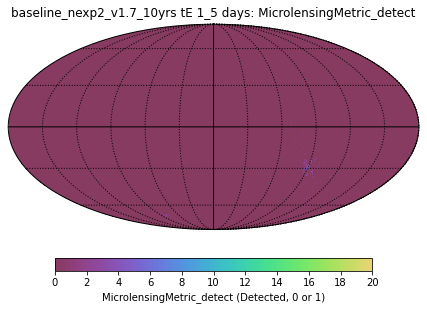

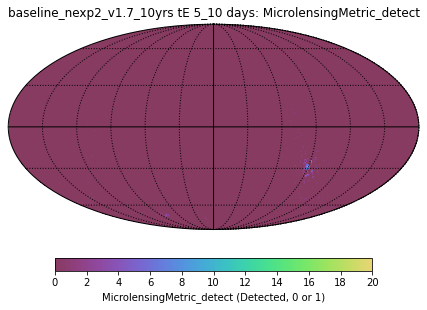

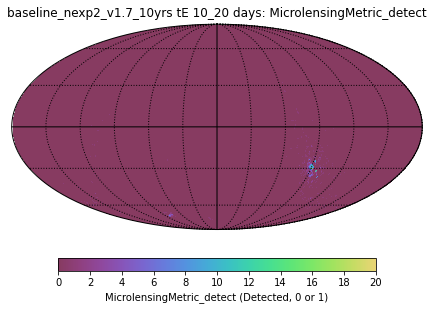

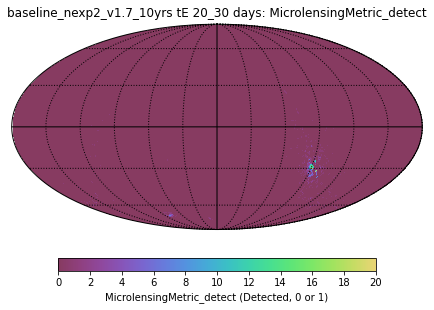

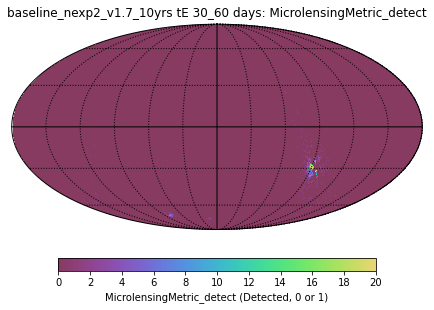

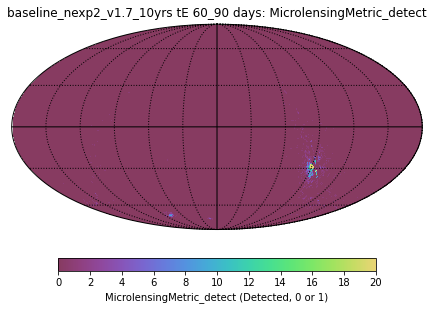

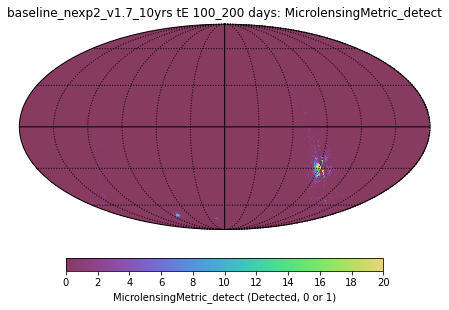

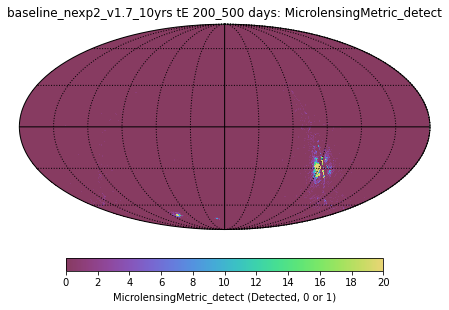

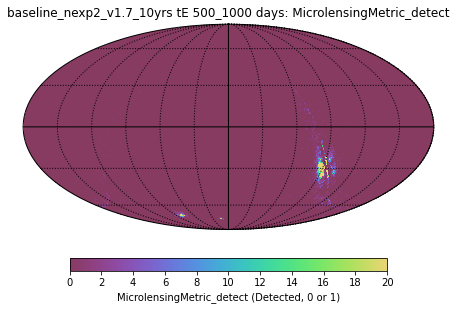

In [18]:
# If you don't want to try and plot N individual points, 
plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0, 'colorMax': 20}
plotFunc = maf.plots.HealpixSkyMap()
ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

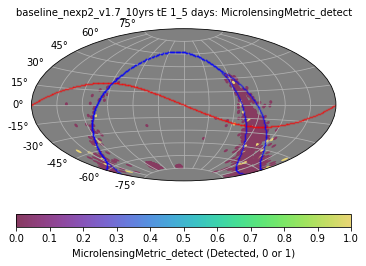

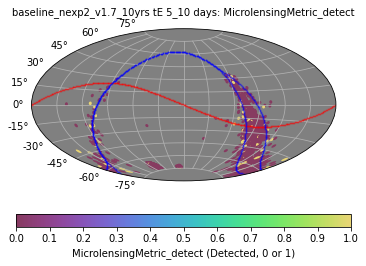

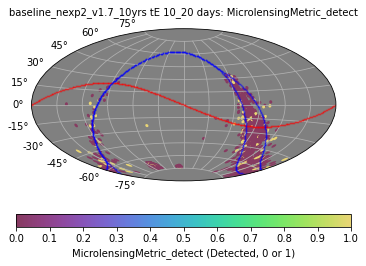

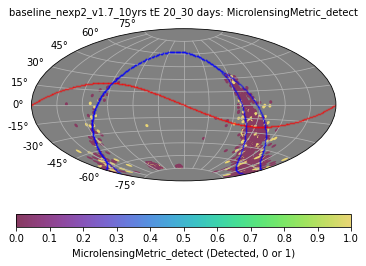

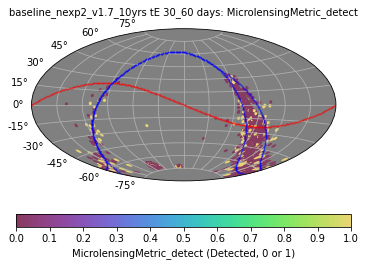

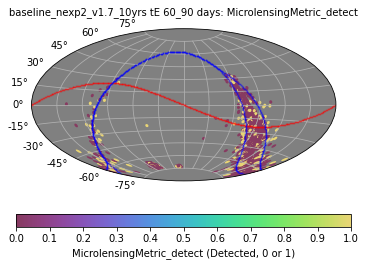

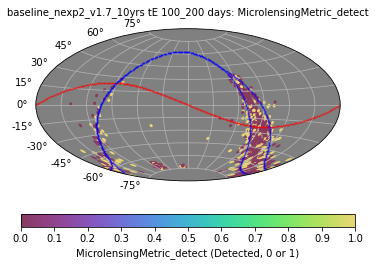

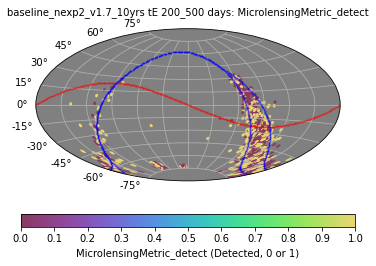

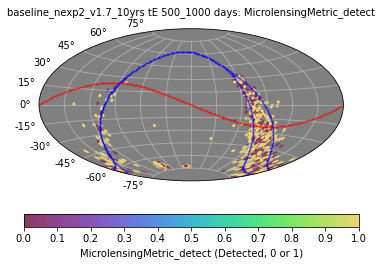

In [19]:
# If you do want to show each individual point - this is slower but shows each individual event
plotFunc = maf.plots.BaseSkyMap()

ph = maf.plots.PlotHandler(outDir=outDir, figformat='png', thumbnail=False)
for k in bundles:
    ph.setMetricBundles([bundles[k]])
    ph.plot(plotFunc=plotFunc)

In [20]:
d = pd.DataFrame([bundles[k].summaryValues for k in bundles.keys()], index=list(bundles.keys()))
d

,Total detected,Total lightcurves in footprint,Total lightcurves on sky,Fraction detected in footprint (mean),Fraction detected of total (mean)
1 to 5,210.0,9992,10000,0.021017,0.0210
5 to 10,409.0,9992,10000,0.040933,0.0409
10 to 20,663.0,9992,10000,0.066353,0.0663
20 to 30,866.0,9992,10000,0.086669,0.0866
30 to 60,1142.0,9992,10000,0.114291,0.1142
60 to 90,1471.0,9992,10000,0.147218,0.1471
100 to 200,2144.0,9992,10000,0.214572,0.2144
200 to 500,3890.0,9992,10000,0.389311,0.3890
500 to 1000,5334.0,9992,10000,0.533827,0.5334


Text(0.5, 1.0, 'Total detected / 10000 as function of crossing time')

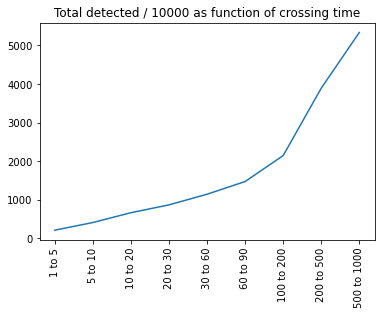

In [21]:
plt.plot(d['Total detected'])
plt.xticks(rotation=90)
plt.title(f'Total detected / {n_events} as function of crossing time')

In [22]:
# Illustrate some things about the metric values: (caught in summary metrics)
m = list(bundles.keys())[-1]
print(f'How many lightcurves were added? (over the entire sky) {len(bundles[m].metricValues)}')
print(f'How many lightcurves were added in areas that were part of the survey footprint?' ,
      f'{len(bundles[m].metricValues.compressed())}')
print(f'What are the metric values for each of these light curves? '
      f'{np.unique(bundles[m].metricValues.compressed())}')
print(f'How many lightcurves were *successfully* detected? {bundles[m].metricValues.sum()}')
print(len(np.where(bundles[m].metricValues == 1)[0]))
frac_total = bundles[m].metricValues.sum() / len(bundles[m].metricValues)
print(f'Fraction of total lightcurves detected {frac_total}')
frac_footprint = bundles[m].metricValues.sum() / len(bundles[m].metricValues.compressed())
print(f'Fraction of lightcurves within footprint detected {frac_footprint}')

How many lightcurves were added? (over the entire sky) 10000
How many lightcurves were added in areas that were part of the survey footprint? 9992
What are the metric values for each of these light curves? [0. 1.]
How many lightcurves were *successfully* detected? 5334.0
5334
Fraction of total lightcurves detected 0.5334
Fraction of lightcurves within footprint detected 0.5338270616493195


In [23]:
d_Npts = pd.DataFrame([bundles_Npts[k].summaryValues for k in bundles_Npts.keys()], index=list(bundles_Npts.keys()))
d_Npts

,Fraction w/ at least 10 points,Total lightcurves in footprint,Total lightcurves on sky,Mean number of points per lightcurves in footprint,Mean number of points per lightcurves in total
1 to 5,0.005604,9992,10000,0.424940,0.4246
5 to 10,0.034027,9992,10000,1.040933,1.0401
10 to 20,0.094576,9992,10000,2.065352,2.0637
20 to 30,0.160829,9992,10000,3.454063,3.4513
30 to 60,0.274119,9992,10000,6.188951,6.1840
60 to 90,0.432046,9992,10000,10.225881,10.2177
100 to 200,0.806845,9992,10000,20.059147,20.0431
200 to 500,0.997298,9992,10000,45.294436,45.2582
500 to 1000,0.999600,9992,10000,91.050440,90.9776


In [24]:
d_Fisher = pd.DataFrame([bundles_Fisher[k].summaryValues for k in bundles_Fisher.keys()], index=list(bundles_Fisher.keys()))
d_Fisher

,Fraction w/ sigma_tE/tE < 0.1,Total lightcurves in footprint,Total lightcurves on sky,Mean sigma_tE/tE in footprint (mean),Mean sigma_tE/tE of total (mean)
1 to 5,0.001001,9992,10000,3.962480e+13,3.959303e+13
5 to 10,0.002702,9992,10000,6.262742e+11,6.257727e+11
10 to 20,0.007206,9992,10000,4.479099e+13,4.475515e+13
20 to 30,0.016113,9992,10000,2.450803e+13,2.448842e+13
30 to 60,0.026621,9992,10000,7.537462e+07,7.531431e+07
60 to 90,0.034628,9992,10000,4.304704e+06,4.301260e+06
100 to 200,0.067654,9992,10000,2.370136e+05,2.368240e+05
200 to 500,0.404223,9992,10000,1.486632e+08,1.485443e+08
500 to 1000,0.671837,9992,10000,1.852029e+02,1.850547e+02


## Preparing metric results and creating figure of merit and comparison plots

In [25]:
results = []
results_compare = []
run_names = []
metric_types = []
min_tEs = []
max_tEs = []

bundle_dicts = [bundles, bundles_Npts, bundles_Fisher]

for bundle_dict in range(len(bundle_dicts)):
    if bundle_dict == 0: #detect metric
        results.extend(d['Fraction detected of total (mean)'])
        #results_compare.extend(d['Fraction detected of total (mean)'])
        metric_types.extend(['detect']*len(bundles.keys()))
    elif bundle_dict == 1: #Npts metric
        results.extend(d_Npts['Mean number of points per lightcurves in total'])
        #results_compare.extend(d_Npts['Fraction w/ at least 10 points'])
        metric_types.extend(['Npts']*len(bundles_Npts.keys()))
    elif bundle_dict == 2: #Fisher metric
        results.extend(d_Fisher['Fraction w/ sigma_tE/tE < 0.1'])
        #results_compare.extend(d_Fisher['Fraction w/ sigma_tE/tE < 0.1'])
        metric_types.extend(['Fisher']*len(bundles_Fisher.keys()))
    for i in bundle_dicts[bundle_dict]:
        results_compare.append(bundle_dicts[bundle_dict][i].metricValues)
        run_names.append(bundle_dicts[bundle_dict][i].runName)
        min_tEs.append(np.int(i.split(' ')[0]))
        max_tEs.append(np.int(i.split(' ')[2]))
        
results = np.array(results)
results_compare = np.array(results_compare)
run_names = np.array(run_names)
metric_types = np.array(metric_types)
min_tEs = np.array(min_tEs)
max_tEs = np.array(max_tEs)

/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_34431/1785821621.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_tEs.append(np.int(i.split(' ')[0]))
/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_34431/1785821621.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

The following figure is intended to be used to compare between different OpSims

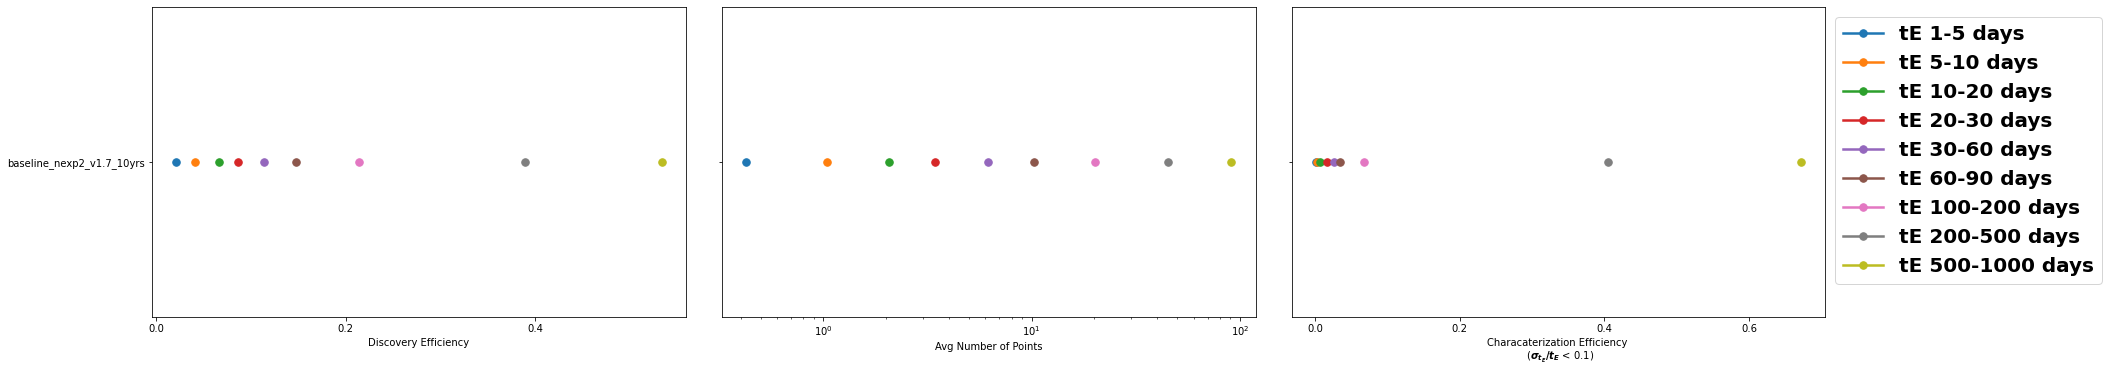

In [26]:
save_folder = 'test_microlensing'
figure_name = 'microlensingFOM'
figsize = (30, 5) # Increase 5 for more metrics
maf.plot_FOM(results, run_names, metric_types, min_tEs, max_tEs, save_folder, figure_name, figsize = figsize)

The following set of figures compares between the discovery/detect metric, number of points metric, and characterization/fisher metric. By default the fraction discovered, the fraction of objects with at least 10 points within 2tE of the peak, and the fraction characterized are compared. The three should all be correlated, but these plots are helpful for knowing how much followup must be done outside of Rubin to characterize events.

/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/runComparison/microlensingCompare.py:386: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([np.nan, "Yes", "No"])
/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/runComparison/microlensingCompare.py:387: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([np.nan, "Yes", "No"])


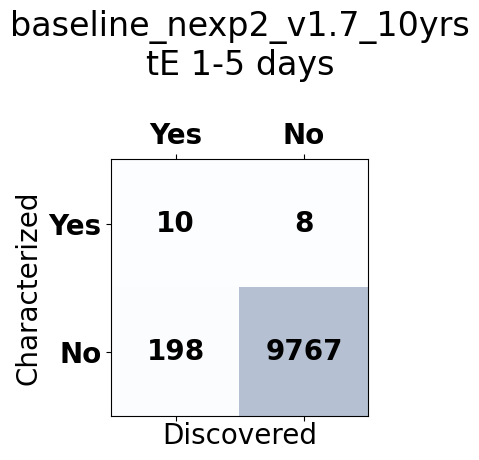

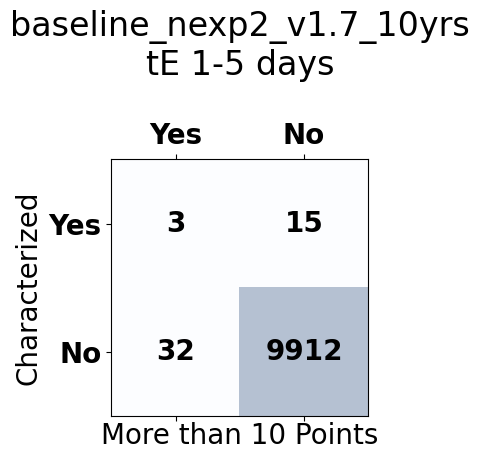

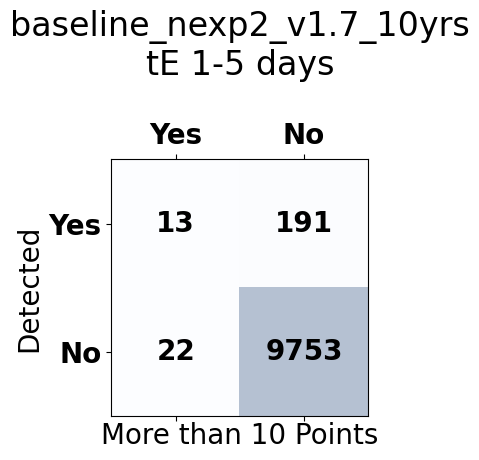

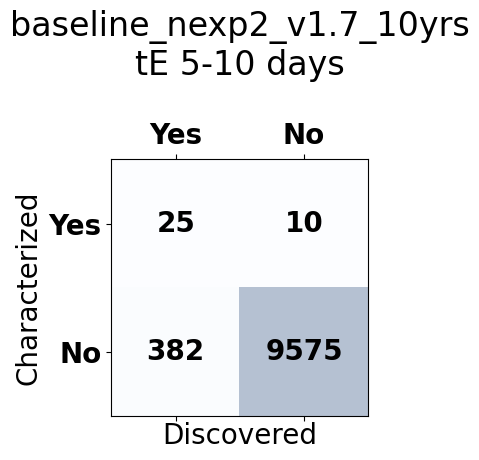

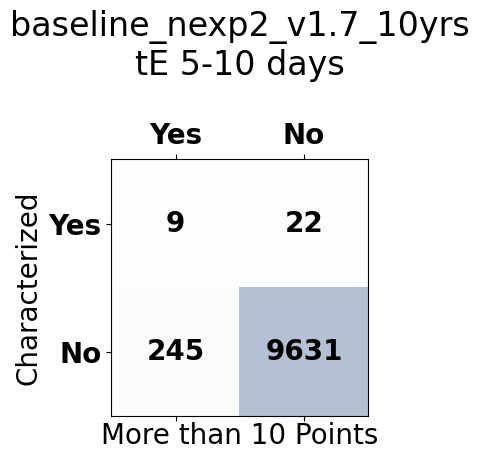

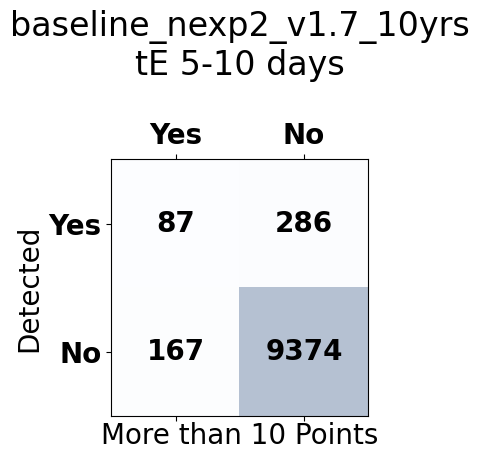

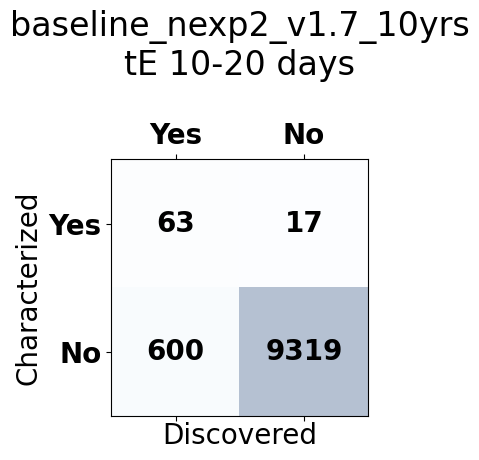

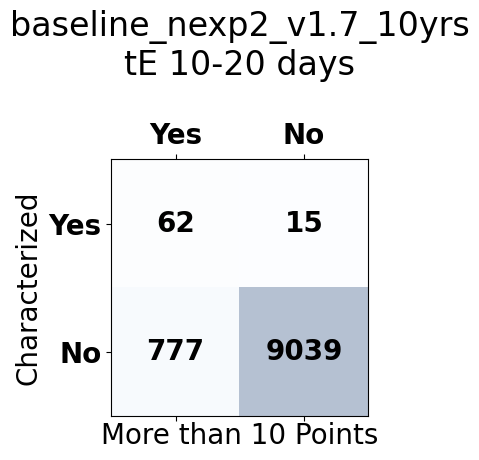

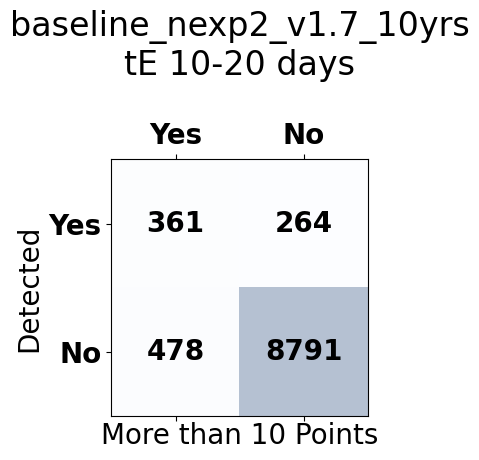

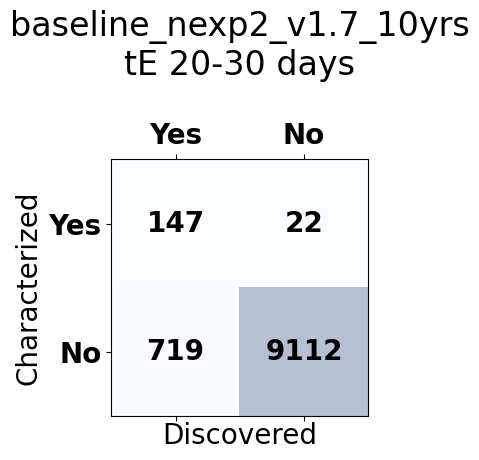

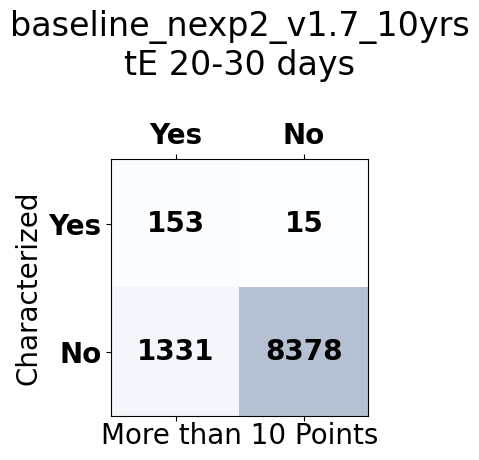

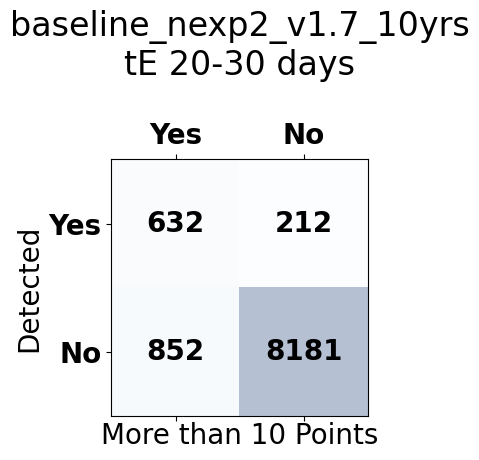

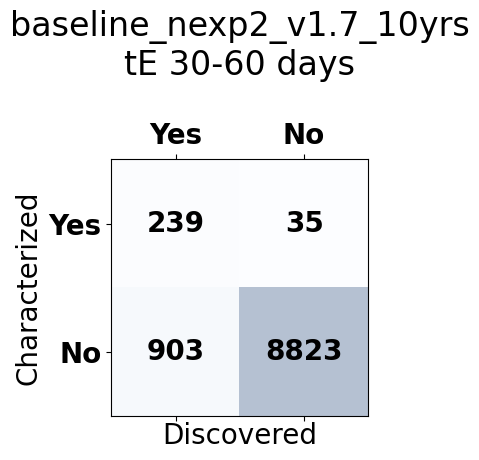

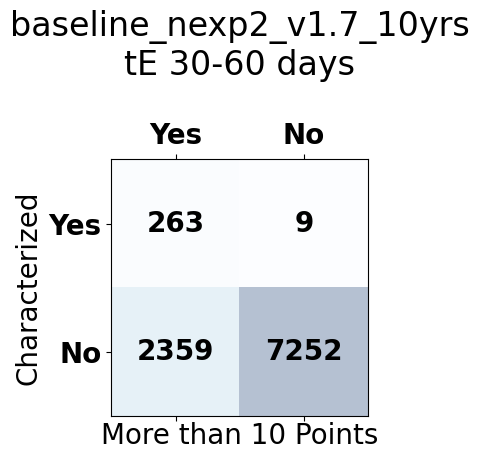

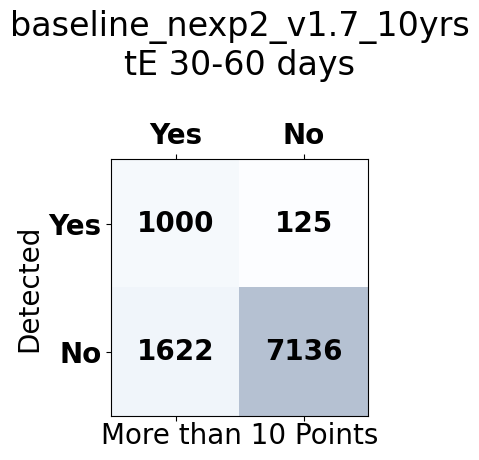

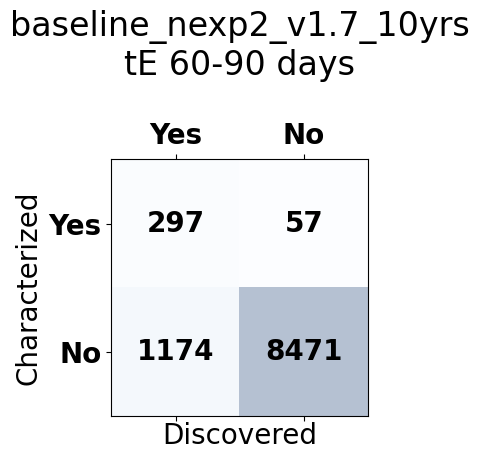

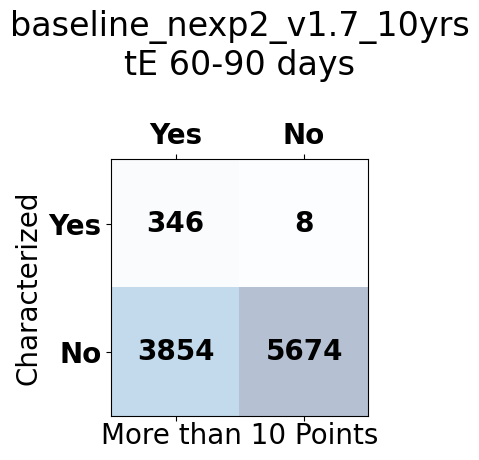

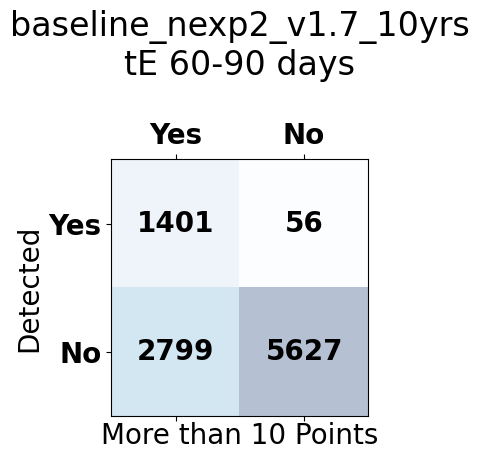

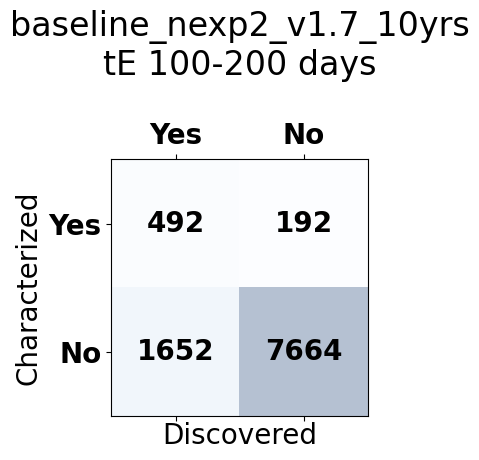

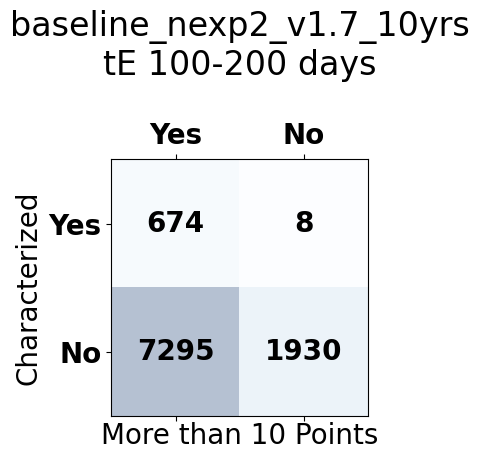

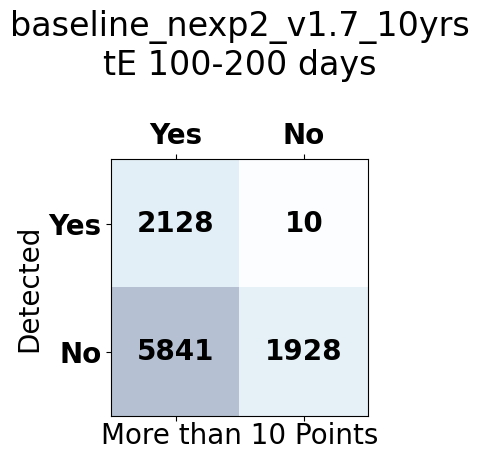

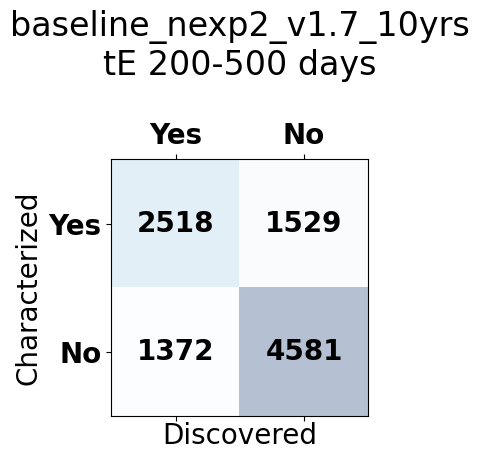

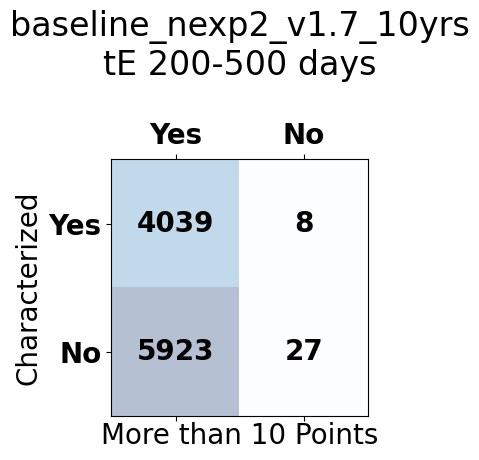

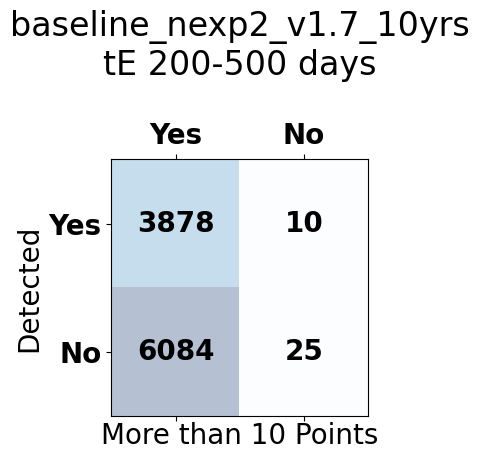

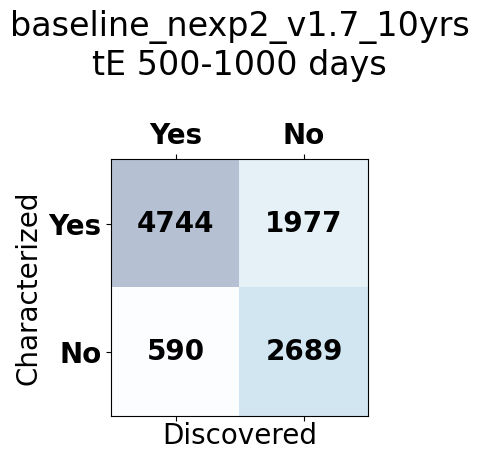

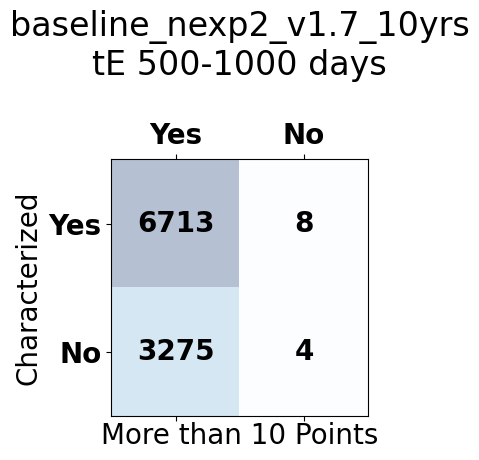

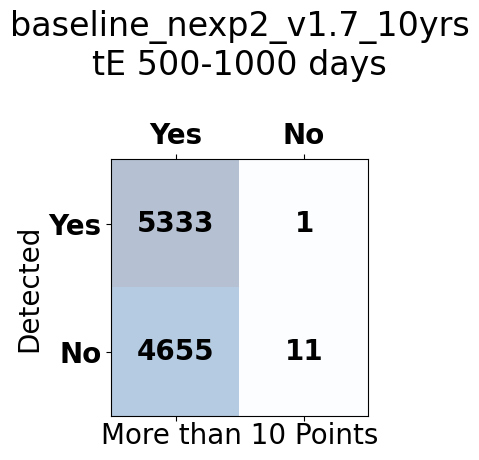

In [27]:
maf.plot_compare(results_compare, run_names, metric_types, min_tEs, max_tEs, save_folder)

## Look at the slicer information (how the lightcurves were added). ##

In [28]:
# The *slicer* keeps the information about the injected lightcurves too
slicer = bundles[m].slicer
print(f'How many lightcurves added over the sky? {len(slicer)}')

How many lightcurves added over the sky? 10000


In [29]:
# What information was recorded for each event
slicer.slicePoints.keys()

dict_keys(['sid', 'ra', 'dec', 'peak_time', 'crossing_time', 'impact_parameter'])

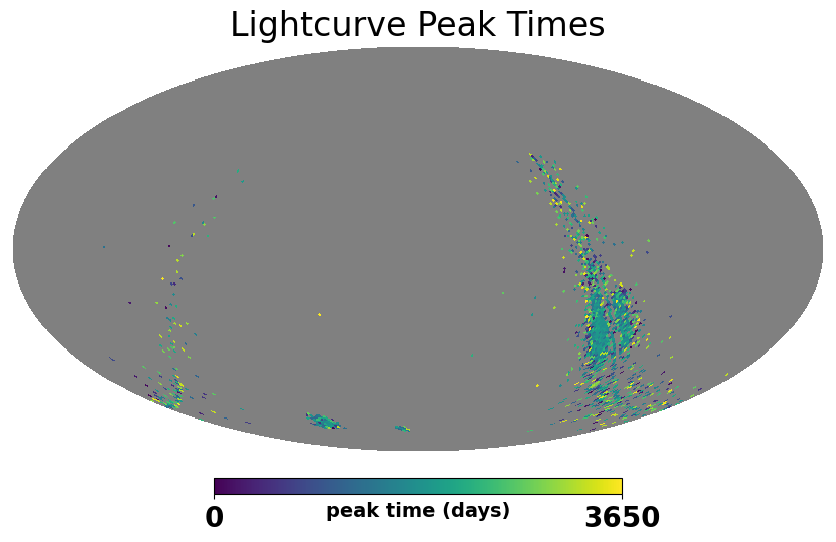

In [30]:
# Including their spatial, time and distance distribution
hp.mollview(rsUtils._healbin(slicer.slicePoints['ra'], slicer.slicePoints['dec'], 
                             slicer.slicePoints['peak_time'], 64, reduceFunc=np.mean), 
            unit='peak time (days)', title='Lightcurve Peak Times', min=0, max=3650)